## Topological Data Analysis - Part 5 - Persistent Homology

This is Part 5 in a series on topological data analysis.
See <a href="TDApart1.html">Part 1</a> | <a href="TDApart2.html">Part 2</a> | <a href="TDApart3.html">Part 3</a> | <a href="TDApart4.html">Part 4</a>

<a href="https://github.com/outlace/OpenTDA/PersistentHomology.py">Download this notebook</a> | <a href="https://github.com/outlace/outlace.github.io/ipython-notebooks/TDA/TDApart5.ipynb">Download the code</a>

In this part we finally utilize all we've learned to compute the persitent homology groups and draw persistence diagrams to summarize the information graphically.

Let's summarize what we know so far.

We know...
1. how to generate a simplicial complex from point-cloud data using an arbitrary $\epsilon$ distance parameter
2. how to calculate homology groups of a simplicial complex
3. how to compute Betti numbers of a simplicial complex

The jump from what we know to persistent homology is small conceptually. We just need to calculate Betti numbers for a set of simplicial complexes generated by continuously varying $\epsilon: 0 \rightarrow \infty$. Then we can see which topological features persist significantly longer than others, and declare those to be signal not noise. 
>Note: I'm ignoring an objective definition of "significantly longer" since that is really a statistical question that is outside the scope of this exposition. For all the examples we consider here, it will be obvious which features persist significantly longer just by visual inspection.

Unfortunately, while the coneptual jump is small, the technical jump is more formidable. Especially because we also want to be able to ask which data points in my original data set lie on some particular topological feature.

Let's revisit the code we used to sample points (with some intentional randomness added) from a circle and build a simplicial complex.

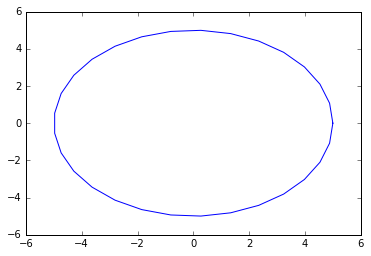

In [3]:
import numpy as np
import matplotlib.pyplot as plt

n = 30 #number of points to generate

#generate space of parameter
theta = np.linspace(0, 2.0*np.pi, n) 

a, b, r = 0.0, 0.0, 5.0

x = a + r*np.cos(theta)
y = b + r*np.sin(theta)

#code to plot the circle for visualization
plt.plot(x, y)
plt.show()

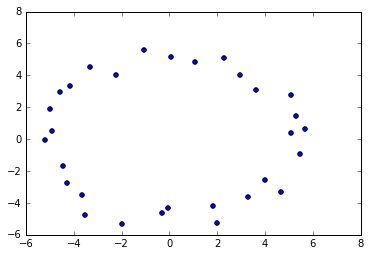

In [15]:
x2 = np.random.uniform(-0.75,0.75,n) + x #add some "jitteriness" to the points
y2 = np.random.uniform(-0.75,0.75,n) + y
fig, ax = plt.subplots()
ax.scatter(x2,y2)
plt.show()

In [129]:
newData = np.array(list(zip(x2,y2)))
import SimplicialComplex

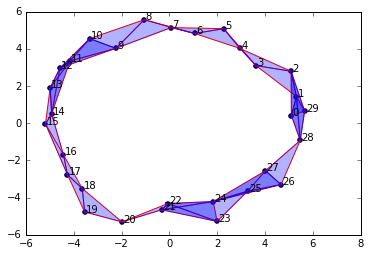

In [16]:
graph = SimplicialComplex.buildGraph(raw_data=newData, epsilon=3.0) #Notice the epsilon parameter is 3.0
ripsComplex = SimplicialComplex.rips(graph=graph, k=3)
SimplicialComplex.drawComplex(origData=newData, ripsComplex=ripsComplex)

As you can see, setting $\epsilon = 3.0$ produces a nice looking simplicial complex that captures the single 1-dimensional "hole" in the original data.

However, let's play around with $\epsilon$ to see how it changes our complex.

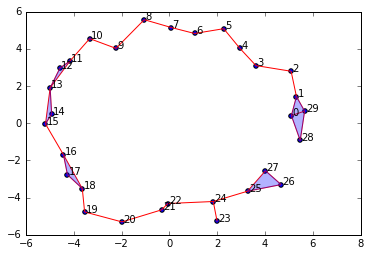

In [17]:
graph = SimplicialComplex.buildGraph(raw_data=newData, epsilon=2.0)
ripsComplex = SimplicialComplex.rips(graph=graph, k=3)
SimplicialComplex.drawComplex(origData=newData, ripsComplex=ripsComplex)

We decreased $\epsilon$ to $2.0$ and now we have a "break" in our circle. If we calculate the homology and Betti numbers of this complex, we will no longer have a 1-dimensional cycle present. We will only see a single connected component. 

Let's decrease it a little bit more to 1.9

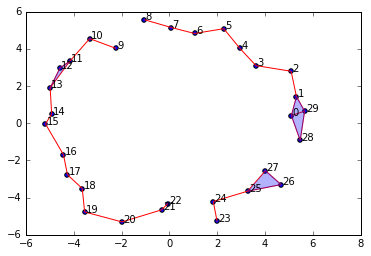

In [19]:
newData = np.array(list(zip(x2,y2)))
graph = SimplicialComplex.buildGraph(raw_data=newData, epsilon=1.9)
ripsComplex = SimplicialComplex.rips(graph=graph, k=3)
SimplicialComplex.drawComplex(origData=newData, ripsComplex=ripsComplex)

Now we have three connected components and no cycles/holes in the complex. Ok, let's go the other direction and increase $\epsilon$ to 4.0

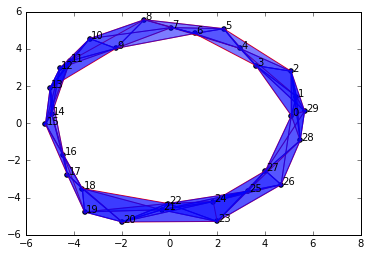

In [21]:
newData = np.array(list(zip(x2,y2)))
graph = SimplicialComplex.buildGraph(raw_data=newData, epsilon=4.0)
ripsComplex = SimplicialComplex.rips(graph=graph, k=3)
SimplicialComplex.drawComplex(origData=newData, ripsComplex=ripsComplex)

Unlike going down by 1, by increasing $\epsilon$ to 4.0, we haven't changed anything about our homology groups. We still have a single connected component and a single 1-dimensional cycle.

Let's make an even bigger jump and set $\epsilon = 7.0$, an increase of 3.

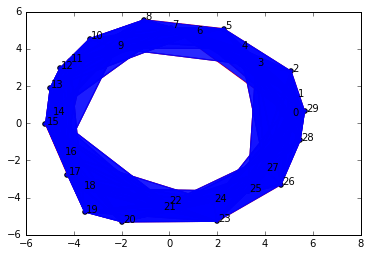

In [22]:
graph = SimplicialComplex.buildGraph(raw_data=newData, epsilon=7.0)
ripsComplex = SimplicialComplex.rips(graph=graph, k=3)
SimplicialComplex.drawComplex(origData=newData, ripsComplex=ripsComplex)

Alas, even though we've gone up by 4 units from our original nice value of 3.0, we still get a complex with the same topological features: a single connected component and a 1-dimensional cycle.

This is the primary insight of __persistence__ in persistent homology. These features are persistent over a wide range of $\epsilon$ scale parameters and thus are likely to be true features of the underlying data rather than noise.

We can diagram our findings with two major styles: a barcode or a persistence diagram (not shown).
Here's what our barcode might look like for the above example:

<img src="images/TDAimages/barcode_example.png" width="500px" />
>NOTE: I've prepared this barcode "by band," i.e. it is not the precise computed barcode. I've highlighted the "true" topological features amongst the noise. $H_0, H_1, H_2$ refer to the respective homology groups and Betti numbers.

Importantly, it is possible that two different true topological features may exist at different scales and thus can only be captured with a persistent homology, they will be missed in a simplicial complex with a single fixed scale. For example, if we have data that presents a large circle next to a small circle, it is possible at a small $\epsilon$ value only the small circle will be connected, giving rise to a single 1-dimensionl hole, then at a larger $\epsilon$ the big circle will be connected and the small circle will get "filled in." So at no single $\epsilon$ value will both circles be revealed.

#### Filtrations

It turns out there is a relatively straightforward way to extend our previous work on calculating Betti numbers with boundary matrices to the setting of persistent homology where we're dealing with collections of ever expanding complexes.

We define a _filtration complex_ as the sequence of simplicial complexes generated by continuously increasing the scale parameter $\epsilon$.

But rather than building multiple simplicial complexes at various $\epsilon$ parameters and then combining them into a sequence, we can just build a single simplicial complex over our data using a large (maximal) $\epsilon$ value. But we will keep track of the distance between all points of pairs (we already do this with the algorithm we wrote) so we know at what $\epsilon$ scale each pair of points form an edge. Thus "hidden" in any simplicial complex at some $\epsilon$ value is a filtration (sequence of nested complexes) up to that value of $\epsilon$.

Here's a really simple example:
<img src="images/TDAimages/simplicialComplex9a.png" />

So if we take the maximum scale, $\epsilon = 4$, our simplicial complex is:
$$ S = \text{ { {0}, {1}, {2}, {0,1}, {2,0}, {1,2}, {0,1,2} } } $$

But if we keep track of the pair-wise distances between points (i.e. the length/weight of all the edges), then we already have the information necessary for a filtration.

Here are the weights (lengths) of each edge (1-simplex) in this simplicial complex (the vertical bars indicate weight/length):
$$ |{0,1}| = 1.4 \\
|{2,0}| = 2.2 \\
|{1,2}| = 3
$$
And this is how we would use that information to build a filtration:
$$
S_0 \subseteq S_1 \subseteq S_2 \\
S_0 = \text{ { {0}, {1}, {2} } } \\
S_1 = \text{ { {0}, {1}, {2}, {0,1} } } \\
S_2 = \text{ { {0}, {1}, {2}, {0,1}, {2,0}, {1,2}, {0,1,2} } } \\
$$

Basically each simplex in a subcomplex of the filtration will appear when its longest edge appears. So the 2-simplex {0,1,2} appears only once the edge {1,2} appears since that edge is the longest and doesn't show up until $\epsilon \geq 2.2$

For it to be a filtration that we can use in our (future) algorithm, it needs to have a __total order__. A total order is an ordering of the simplices in our filtration such that there is a valid "less than" relationship between any two simplices (i.e. no two simplices are equal in "value"). The most famous example of a set with a total order would be the natural numbers {0,1,2,3,4...} since no two numbers are equal, we can always say one number is greater than or less than another.

How do we determine the "value" (henceforth: filter value) of a simplex in a filtration (and thus determine the ordering of the filtration)? Well I already said part of it. The filter value of a simplex is partly determined by the length of its maximum edge. But sometimes two distinct simplices have maximum edges of the same length, so we have to define a heirarchy of rules for determining the value (the ordering) of our simplices.

For any two simplices, $\sigma_1, \sigma_2$...
1. 0-simplices must be less than 1-simplices must be less than 2-simplices, etc. This implies that any face of a simplex (i.e. $f \subset \sigma$) is automatically less than (comes before in the ordering) of the simplex. I.e. if $dim(\sigma_1) < dim(\sigma_2) \implies \sigma_1 < \sigma_2$ (dim = dimension, the symbol $\implies$ means "implies").
<br /><br />
2. If $\sigma_1, \sigma_2$ are of an equal dimension (and hence one is not the face of the other), then the value of each simplex is determined by its longest (highest weight) 1-simplex (edge). In our example above, $\{0,1\} \lt \{2,0\} \lt \{1,2\}$ due to the weights of each of those. To compare higher-dimensional simplices, you still just compare them by the value of their greatest edge. I.e. if $dim(\sigma_1) = dim(\sigma_2)$ then $max\_edge(\sigma_1) < max\_edge(\sigma_2) \implies \sigma_1 < \sigma_2$
<br /><br />
3. If $\sigma_1,\sigma_2$ are of an equal dimension AND their longest edges are of equal value (i.e. their maximum weight edges enter the filtration at the same $\epsilon$ value), then $max\_vertex(\sigma_1) < max\_vertex(\sigma_2) \implies \sigma_1 < \sigma_2$. What is a maximum node? Well we just have to place an arbitrary ordering over the vertices even though they all appear at the same time.

>Just as an aside, we just discussed a _total order_. The corollary to that idea is a _partial order_ where we have "less than" relationships defined between some but not all elements, and some elements may be equal to others.

Remember from part 3 how we setup the boundary matrices by setting the columns to represent the n-simplices in the n-chain group and the rows to represent the (n-1)-simplices in the (n-1)-chain group? Well we can extend this procedure to calculate Betti numbers across an entire filtration complex in the following way.

Let's use the filtration from above:
$$
S_0 \subseteq S_1 \subseteq S_2 \\
S_0 = \text{ [ {0}, {1}, {2} } ] \\
S_1 = \text{ [ {0}, {1}, {2}, {0,1} ] } \\
S_2 = S = \text{ [ {0}, {1}, {2}, {0,1}, {2,0}, {1,2}, {0,1,2} ] } \\
$$
Notice I already have the simplices in each subcomplex of the filtration in order (I've imposed a total order on the set of simplices) indicated by the square brackets rather than curly braces (although I may abuse this notation).

So we'll build a boundary matrix for the full filtration in the same way we built individual boundary matrices for each homology group before. We'll make a square matrix where the columns (label: $j$) and rows (label: $i$) are the simplices in the filtration in their proper (total) order. 

Then, as before, we set each cell $[i,j] = 1$ if $\sigma_i$ is a face of $\sigma_j$ ($\sigma$ meaning simplex). All other cells are $0$.

Here's what it looks like in our very small filtration from above:

$$
\partial_{filtration} =
\begin{array}{c|lcr}
\partial & \{0\} & \{1\} & \{2\} & \{0,1\} & \{2,0\} & \{1,2\} & \{0,1,2\} \\
\hline
\{0\} & 0 & 0 & 0 & 1 & 1 & 0 & 0 \\
\{1\} & 0 & 0 & 0 & 1 & 0 & 1 & 0 \\
\{2\} & 0 & 0 & 0 & 0 & 1 & 1 & 0 \\
\{0,1\} & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
\{2,0\} & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
\{1,2\} & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
\{0,1,2\} & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
\end{array}
$$

As before, we will apply an algorithm to change the form of this matrix. However, unlike before, we are now going to convert this boundary matrix into Smith normal form, we are going to change it into something else called column-echelon form. This conversion process is called a __matrix reduction__, implying we're kind of reducing it into a simpler form.

##### Matrix reduction

Now here's where I have to apologize for a mistake I made in our last post, because I never explained _why_ we had to convert our boundary matrix into Smith normal form, I just told you _how_ to do it.

So here's the deal, our boundary matrices from before gave us a linear map from a n-chain group down to the (n-1)-chain group. We could just multiply the boundary matrix by any element in the n-chain and the result would be the corresponding (mapped) element in the (n-1)-chain. When we reduced the matrix to Smith normal form, we altered the boundary matrix such that we can no longer just multiply by it to map elements in that way. What we did was actually apply another linear map over our boundary matrix, the result being the Smith normal form.

More formally, the Smith normal form $R$ of a matrix $A$ is the matrix product: $R = SAT$ where $S,T$ are other matrices. Hence we have a composition of linear maps that forms $R$, and we can in principle decompose $R$ into the individual linear maps (matrices) that compose it.

So the algorithm for reducing to Smith normal form is essentially finding two other matrices $S,T$ such that $SAT$ produces a matrix with 1s along the diagonal (at least partially).

But why do we do that? Well remember that a matrix being a linear map means it maps one vector space to another. If we have a matrix $M: V_1 \rightarrow V_2$, then it is mapping the basis vectors in $V_1$ to basis vectors in $V_2$. So when we reduce a matrix, we're essentially redefining the basis vectors in each vector space. It just so happens that Smith normal form finds the bases that form cycles and boundaries. There are many different types of reduced matrix forms that have useful interpretations and properties. I'm not going to get into anymore of the mathematics about it here, I just wanted to give a little more explanation to this voo doo matrix reduction we're doing.

When we reduce a filtration boundary matrix into column-echelon form via an algorithm, it tells us the information about when certain topological features at each dimension are formed or "die" (by being subsumed into a larger feature) at various stages in the filtration (i.e. at increasing values of $\epsilon$, via our total order implied on the filtration). Hence, once we reduce the boundary matrix, all we need to do is read off the information as intervals when features are born and die, and then we can graph those intervals as a barcode plot.

The column-echelon form $C$ is likewise a composition of linear maps such that $C = VB$ where $V$ is some matrix that makes the composition work, and $B$ is a filtration boundary matrix. We will actually keep a copy of $V$ once we're done reducing $B$ because $V$ records the information necessary to dermine which data points lie on interesting topological features.

The general algorithm for reducing a matrix to column-echelon form is a type of <a src="https://en.wikipedia.org/wiki/Gaussian_elimination">Gaussian elemination</a>:

```python
for j = 1 to n
    while there exists i < j with low(i) = low(j) 
        add column i to column j
    end while
end for
```

The function `low` accepts a column `j` and returns the row index with the lowest $1$. For example, if we have a column of a matrix: 
$ j = \begin{pmatrix}  1 \\ 0 \\1 \\1 \\ 0 \\0 \\0 \end{pmatrix} $<br />
Then `low(j) = 3` (with indexing starting from 0) since the lowest $1$ in the column is in the fourth row (which is index 3).

So basically the algorithm scans each column in the matrix from left to right, so if we're currently at column `j`, the algorithm looks for all the columns `i` before `j` such that `low(i) == low(j)`, and if it finds such a column `i`, it will add that column to `j`. And we keep a log of everytime we add a column to another in the form of another matrix. If a column is all zeros, then `low(j) = -1` (meaning undefined).

Let's try out the algorithm by hand on our boundary matrix from above. I've removed the column/row labels to be more concise:

$$
\partial_{filtration} =
\begin{Bmatrix}
0 & 0 & 0 & 1 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 1 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 \\
\end{Bmatrix}
$$

So remember, columns are some index `j` and rows are some index `i`. We scan from left to right. The first 3 columns are all zeros so `low(j)` is undefined and we don't do anything. And when we get to column 4 (index `j=3`), since all the prior columns were zero, then there's also nothing to do. When we get to column 5 (index `j=4`), then `low(4) = 2` and `low(3) = 1` so since `low(4) != low(3)` we don't do anything and just move on. It isn't until we get to column 6 (index `j=5`) that there is a column `i < j` (in this case column `4 < 5`) such that `low(4) = low(5)`. So we add column 5 to column 6. Since these are binary (using the field $\mathbb Z_2$) columns, $1+1=0$. The result of adding column 5 to 6 is shown below:

$$
\partial_{filtration} =
\begin{Bmatrix}
0 & 0 & 0 & 1 & 1 & 1 & 0 \\
0 & 0 & 0 & 1 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 \\
\end{Bmatrix}
$$

Now we continue on to the end, and the last column's lowest 1 is in a unique row so we don't do anything. Now we start again from the beginning on the left. We get to column 6 (index `j=5`) and we find that column 4 has the same lowest 1, `low(3) = low(5)`, so we add column 4 to 6. The result is shown below:

$$
\partial_{filtration} =
\begin{Bmatrix}
0 & 0 & 0 & 1 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 \\
\end{Bmatrix}
$$

Look, we now have a new column of all zeros! What does this mean? Well it means that column is a new topological feature. It either represent a connected component or some n-dimensional cycle. In this case it represents a 1-dimensional cycle, the cycle formed from the three 1-simplices.

Notice now that the matrix is fully reduced to column-echelon form since all the lowest $1$s are in unique rows, so our algorithm halts in satisfaction. Now that the boundary matrix is reduced, it is no longer the case that each column and row represents a single simplex in the filtration. Since we've been adding columns together, each column may represent multiple simplices in the filtration. In this case, we only added columns together two times and both we're adding to column 6 (index `j =  5`), so column 6 represents the simplices from columns 4 and 5 (which happen to be {0,1} and {2,0}). So column 6 is the group of simplices: $\text{ {0,1}, {2,0}, {1,2} }$, and if you refer back to the graphical depiction of the simplex, those 1-simplices form a 1-dimensional cycle (albeit immediately killed off by the 2-simplex {0,1,2}).

It is important to keep track of what the algorithm does so we can find out what each column represents when the algorithm is done. We do this by setting up another matrix that I call the _memory matrix_. It starts off just being the identity matrix with the same dimensions as the boundary matrix.

$$
M_{memory} =
\begin{Bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 \\
\end{Bmatrix}
$$

But everytime we add a column `i` to column `j` in our reducing algorithm, we record the change in the memory matrix by putting a `1` in the cell `[i,j]`. So in our case, we recorded the events of adding columns 4 and 5 to column 6. Hence in our memory matrix, we will put a 1 in the cells `[3,5]` and `[4,5]` (using indices). This is shown below:

$$
M_{memory} =
\begin{Bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 1 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 \\
\end{Bmatrix}
$$

Once the algorithm is done running, we can always refer to this memory matrix to remember what the algorithm actually did and figure out what the columns in the reduced boundary matrix represent.

Let's refer back to our _reduced_ (column-echelon form) boundary matrix of the filtration:

$$
\partial_{reduced} =
\begin{Bmatrix}
0 & 0 & 0 & 1 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 \\
\end{Bmatrix}
$$

To record the intervals of birth and death of topological features, we simply scan each column from left to right. If column `j` has all zeros (i.e. `low(j) = -1`) then we record this as the birth of a new feature (being whatever column `j` represents, maybe a single simplex, maybe a group of simplices). 

Otherwise, if a column is not all zeros but has some 1s in it, then we say that the column with index equal to `low(j)` dies at `j`, and hence is the end point of the interval for that feature.

So in our case, all three vertices (the first three columns) are new features that are born (their columns are all zeros, `low(j) = -1`) so we record 3 new intervals with starting points being their column indices. Since we're scanning sequentially from left to right, we don't yet know if or when these features will die, so we'll just tentatively set the end point as `-1` to indicate the end or infinity. Here are the first three intervals:
```python
#Remember the start and end points are column indices
[0,-1], [1,-1], [2,-1]
```
Then we keep scanning left to right and hit column 4 (index `j=3`) and we calculate `low(3) = 1`. So this means the feature that was born in column `j=1` (column 2) just died at `j=3`. Now we can go back and update the tentative end point for that interval, our update intervals being:
```python
#updating intervals...
[0,-1], [1,3], [2,-1]
```

So we just continue this process until the last column and we get all our intervals:

```python
#The final set of intervals
[0,-1], [1,3], [2,4], [5,6]
```

The first three features are 0-simplices and since they are dimension 0, they represent the connected components of the filtration. The 4th feature is the 1-dimensional cycle since its interval indices refer to a group of 1-simplices.

Believe it or not, we've just done persistent homology. That's all there is to it. Once we have the intervals, all we need to do is graph them as a barcode. We should convert the start/end points in these intervals to values of $\epsilon$ by referring back to our set of weights on the edges and assigning an $\epsilon$ value (the value of $\epsilon$ the results in the formation of a particular simplex in the filtration) to each simplex. Here's the barcode:

<img src="images/TDAimages/barcode_example2.png" width="300px" />

>I drew a dot in the $H_1$ group to indicate that the 1-dimensional cycle is born and immediately dies at the same point (since as soon as it forms the 2-simplex subsumes it). Most real barcodes do not produce those dots. We don't care about such ephemeral features.

Notice how we have a bar in the $H_0$ group that is significantly longer than the other two. This suggests our data has only 1 connected component. Groups $H_1, H_2$ don't really have any bars so our data doesn't have any true holes/cycles. Of course with a more realistic data set we would expect to find some cycles.

#### Let's write some code

Alright, so we've basically covered the conceptual framework for computing persistent homology. Let's actually write some code to compute persistent homology on (somewhat) realistic data. I'm not going to spend too much effort explaining all the code and how it works since I'm more concerned with explaining in more abstract terms so you can go write your own algorithms. I've tried to add inline comments that should help. Also keep in mind that since this is educational, these algorithms and data structures will _not_ be very efficient, but will be simple. I hope to write a follow up post at some point that demonstrates how we can make efficient versions of these algorithms and data structures.

Let's start by constructing a simple simplicial complex using the code we wrote in part 4.

In [4]:
data = np.array([[1,4],[1,1],[6,1],[6,4]])

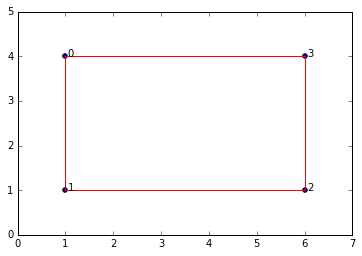

In [467]:
#for example... this is with a small epsilon, to illustrate the presence of a 1-dimensional cycle
graph = SimplicialComplex.buildGraph(raw_data=data, epsilon=5.1)
ripsComplex = SimplicialComplex.rips(nodes=graph[0], edges=graph[1], k=3)
SimplicialComplex.drawComplex(origData=data, ripsComplex=ripsComplex, axes=[0,7,0,5])

So our simplicial complex is just a box. It obviously has 1 connected component and a 1-dimensional cycle. If we keep increasing $\epsilon$ then the box will "fill in" and we'll get a maximal simplex with all four points forming a 3-dimensional simplex (tetrahedron).

>Note, I have modified the `SimplicialComplex` library a bit (mostly cosmetic/stylistic changes) since <a href="http://outlace.com/Topological+Data+Analysis+Tutorial+-+Part+4/">part 4</a>. Refer to the <a href="https://github.com/outlace/outlace.github.io">GitHub project</a> for changes.

Next we're going to modify the functions from the original `SimplicialComplex` library from part 4 so that it works well with a filtration complex rather than ordinary simplicial complexes.

So I'm just going to drop a block of code on you know and describe what each function does. The `buildGraph` function is the same as before. But we have a several new functions: `ripsFiltration`, `getFilterValue`, `compare` and `sortComplex`.

The `ripsFiltration` function accepts the graph object from `buildGraph` and maximal dimension `k` (e.g. up to what dimensional simpices we will bother calculating) and returns a simplicial complex object sorted by filter values. The filter values are determined as described above. We have a `sortComplex` function that takes a complex and filter values and returns the sorted complex.

So the only difference between our previous simplicial complex function and the `ripsFiltration` function is that the latter also generates filter values for each simplex in the complex and imposes a total order on the simplices in the filtration.

In [5]:
import itertools
import functools

In [8]:
def euclidianDist(a,b): #this is the default metric we use but you can use whatever distance function you want
    return np.linalg.norm(a - b) #euclidian distance metric


#Build neighorbood graph
def buildGraph(raw_data, epsilon = 3.1, metric=euclidianDist): #raw_data is a numpy array
    nodes = [x for x in range(raw_data.shape[0])] #initialize node set, reference indices from original data array
    edges = [] #initialize empty edge array
    weights = [] #initialize weight array, stores the weight (which in this case is the distance) for each edge
    for i in range(raw_data.shape[0]): #iterate through each data point
        for j in range(raw_data.shape[0]-i): #inner loop to calculate pairwise point distances
            a = raw_data[i]
            b = raw_data[j+i] #each simplex is a set (no order), hence [0,1] = [1,0]; so only store one
            if (i != j+i):
                dist = metric(a,b)
                if dist <= epsilon:
                    edges.append({i,j+i}) #add edge if distance between points is < epsilon
                    weights.append(dist)
    return nodes,edges,weights

def lower_nbrs(nodeSet, edgeSet, node): #lowest neighbors based on arbitrary ordering of simplices
    return {x for x in nodeSet if {x,node} in edgeSet and node > x}

def ripsFiltration(graph, k): #k is the maximal dimension we want to compute (minimum is 1, edges)
    nodes, edges, weights = graph
    VRcomplex = [{n} for n in nodes]
    filter_values = [0 for j in VRcomplex] #vertices have filter value of 0
    for i in range(len(edges)): #add 1-simplices (edges) and associated filter values
        VRcomplex.append(edges[i])
        filter_values.append(weights[i])
    if k > 1:
        for i in range(k):
            for simplex in [x for x in VRcomplex if len(x)==i+2]: #skip 0-simplices and 1-simplices
                #for each u in simplex
                nbrs = set.intersection(*[lower_nbrs(nodes, edges, z) for z in simplex])
                for nbr in nbrs:
                    newSimplex = set.union(simplex,{nbr})
                    VRcomplex.append(newSimplex)
                    filter_values.append(getFilterValue(newSimplex, VRcomplex, filter_values))

    return sortComplex(VRcomplex, filter_values) #sort simplices according to filter values

def getFilterValue(simplex, edges, weights): #filter value is the maximum weight of an edge in the simplex
    oneSimplices = list(itertools.combinations(simplex, 2)) #get set of 1-simplices in the simplex
    max_weight = 0
    for oneSimplex in oneSimplices:
        filter_value = weights[edges.index(set(oneSimplex))]
        if filter_value > max_weight: max_weight = filter_value
    return max_weight


def compare(item1, item2): 
    #comparison function that will provide the basis for our total order on the simpices
    #each item represents a simplex, bundled as a list [simplex, filter value] e.g. [{0,1}, 4]
    if len(item1[0]) == len(item2[0]):
        if item1[1] == item2[1]: #if both items have same filter value
            if sum(item1[0]) > sum(item2[0]):
                return 1
            else:
                return -1
        else:
            if item1[1] > item2[1]:
                return 1
            else:
                return -1
    else:
        if len(item1[0]) > len(item2[0]):
            return 1
        else:
            return -1

def sortComplex(filterComplex, filterValues): #need simplices in filtration have a total order
    #sort simplices in filtration by filter values
    pairedList = zip(filterComplex, filterValues)
    #since I'm using Python 3.5+, no longer supports custom compare, need conversion helper function..its ok
    sortedComplex = sorted(pairedList, key=functools.cmp_to_key(compare)) 
    sortedComplex = [list(t) for t in zip(*sortedComplex)]
    #then sort >= 1 simplices in each chain group by the arbitrary total order on the vertices
    orderValues = [x for x in range(len(filterComplex))]
    return sortedComplex

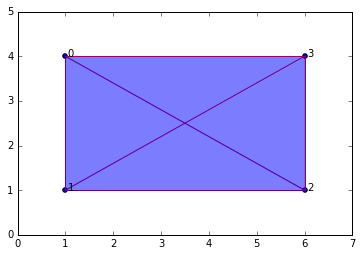

In [47]:
graph2 = buildGraph(raw_data=data, epsilon=7) #epsilon = 9 will build a "maximal complex"
ripsComplex2 = ripsFiltration(graph2, k=3)
SimplicialComplex.drawComplex(origData=data, ripsComplex=ripsComplex2[0], axes=[0,7,0,5])

In [48]:
ripsComplex2

[[{0},
  {1},
  {2},
  {3},
  {0, 1},
  {2, 3},
  {1, 2},
  {0, 3},
  {0, 2},
  {1, 3},
  {0, 1, 2},
  {0, 1, 3},
  {0, 2, 3},
  {1, 2, 3},
  {0, 1, 2, 3}],
 [0,
  0,
  0,
  0,
  3.0,
  3.0,
  5.0,
  5.0,
  5.8309518948453007,
  5.8309518948453007,
  5.8309518948453007,
  5.8309518948453007,
  5.8309518948453007,
  5.8309518948453007,
  5.8309518948453007]]

In [15]:
#return the n-simplices and weights in a complex
def nSimplices(n, filterComplex):
    nchain = []
    nfilters = []
    for i in range(len(filterComplex[0])):
        simplex = filterComplex[0][i]
        if len(simplex) == (n+1):
            nchain.append(simplex)
            nfilters.append(filterComplex[1][i])
    if (nchain == []): nchain = [0]
    return nchain, nfilters

#check if simplex is a face of another simplex
def checkFace(face, simplex):
    if simplex == 0:
        return 1
    elif (set(face) < set(simplex) and ( len(face) == (len(simplex)-1) )): #if face is a (n-1) subset of simplex
        return 1
    else:
        return 0
    
#build boundary matrix for dimension n ---> (n-1) = p
def filterBoundaryMatrix(filterComplex):
    bmatrix = np.zeros((len(filterComplex[0]),len(filterComplex[0])), dtype='>i8')
    #bmatrix[0,:] = 0 #add "zero-th" dimension as first row/column, makes algorithm easier later on
    #bmatrix[:,0] = 0
    i = 0
    for colSimplex in filterComplex[0]:
        j = 0
        for rowSimplex in filterComplex[0]:
            bmatrix[j,i] = checkFace(rowSimplex, colSimplex)
            j += 1
        i += 1
    return bmatrix

In [49]:
bm = filterBoundaryMatrix(ripsComplex2)
bm #Here is the (non-reduced) boundary matrix

array([[0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

The following functions are for reducing the boundary matrix as described above (when we did it by hand).

In [71]:
#returns row index of lowest "1" in a column i in the boundary matrix
def low(i, matrix):
    col = matrix[:,i]
    col_len = len(col)
    for i in range( (col_len-1) , -1, -1): #loop through column from bottom until you find the first 1
        if col[i] == 1: return i
    return -1 #if no lowest 1 (e.g. column of all zeros), return -1 to be 'undefined'

#checks if the boundary matrix is fully reduced
def isReduced(matrix):
    for j in range(matrix.shape[1]): #iterate through columns
        for i in range(j): #iterate through columns before column j
            low_j = low(j, matrix)
            low_i = low(i, matrix)
            if (low_j == low_i and low_j != -1):
                return i,j #return column i to add to column j
    return [0,0]

#the main function to iteratively reduce the boundary matrix
def reduceBoundaryMatrix(matrix): 
    #this refers to column index in the boundary matrix
    reduced_matrix = matrix.copy()
    matrix_shape = reduced_matrix.shape
    memory = np.identity(matrix_shape[1], dtype='>i8') #this matrix will store the column additions we make
    r = isReduced(reduced_matrix)
    while (r != [0,0]):
        i = r[0]
        j = r[1]
        col_j = reduced_matrix[:,j]
        col_i = reduced_matrix[:,i]
        #print("Mod: add col %s to %s \n" % (i+1,j+1)) #Uncomment to see what mods are made
        reduced_matrix[:,j] = np.bitwise_xor(col_i,col_j) #add column i to j
        memory[i,j] = 1
        r = isReduced(reduced_matrix)
    return reduced_matrix, memory

In [56]:
z = reduceBoundaryMatrix(bm)
z

Mod: add col 6 to 8 

Mod: add col 7 to 8 

Mod: add col 5 to 8 

Mod: add col 7 to 9 

Mod: add col 5 to 9 

Mod: add col 6 to 10 

Mod: add col 7 to 10 

Mod: add col 11 to 13 

Mod: add col 12 to 14 

Mod: add col 13 to 14 



(array([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        

So the `reduceBoundaryMatrix` function returns two matrices, the reduced boundary matrix and a _memory_ matrix that records all the actions of the reduction algorithm. This is necessary so we can look up what each column in the boundary matrix actually refers to. Once it's reduced each column in the boundary matrix is not necessarily a single simplex but possibly a group of simplices such as some n-dimensional cycle.

The following functions use the reduced matrix to read the intervals for all the features that are born and die throughout the filtration

In [99]:
def readIntervals(reduced_matrix, filterValues): #reduced_matrix includes the reduced boundary matrix AND the memory matrix
    #store intervals as a list of 2-element lists, e.g. [2,4] = start at "time" point 2, end at "time" point 4
    #note the "time" points are actually just the simplex index number for now. we will convert to epsilon value later
    intervals = []
    #loop through each column j
    #if low(j) = -1 (undefined, all zeros) then j signifies the birth of a new feature j
    #if low(j) = i (defined), then j signifies the death of feature i
    for j in range(reduced_matrix[0].shape[1]): #for each column (its a square matrix so doesn't matter...)
        low_j = low(j, reduced_matrix[0])
        if low_j == -1:
            interval_start = [j, -1]
            intervals.append(interval_start) # -1 is a temporary placeholder until we update with death time
            #if no death time, then -1 signifies feature has no end (start -> infinity)
            #-1 turns out to be very useful because in python if we access the list x[-1] then that will return the
            #last element in that list. in effect if we leave the end point of an interval to be -1
            # then we're saying the feature lasts until the very end
        else: #death of feature
            feature = intervals.index([low_j, -1]) #find the feature [start,end] so we can update the end point
            intervals[feature][1] = j #j is the death point
            #if the interval start point and end point are the same, then this feature begins and dies instantly
            #so it is a useless interval and we dont want to waste memory keeping it
            epsilon_start = filterValues[intervals[feature][0]]
            epsilon_end = filterValues[j]
            if epsilon_start == epsilon_end: intervals.remove(intervals[feature])
            
    return intervals

def readPersistence(intervals, filterComplex): 
    #this converts intervals into epsilon format and figures out which homology group each interval belongs to
    persistence = []
    for interval in intervals:
        start = interval[0]
        end = interval[1]
        homology_group = (len(filterComplex[0][start]) - 1) #filterComplex is a list of lists [complex, filter values]
        epsilon_start = filterComplex[1][start]
        epsilon_end = filterComplex[1][end]
        persistence.append([homology_group, [epsilon_start, epsilon_end]])
        
    return persistence

In [100]:
intervals = readIntervals(z, ripsComplex2[1])
intervals

[[0, -1], [1, 4], [2, 6], [3, 5], [7, 12]]

So those are all the intervals for the features that arise and die. The `readPersistence` function will just convert the start/end points from being indices in the boundary matrix to their corresponding $\epsilon$ value. It will also figure out to which homology group (i.e. which Betti number dimension) each interval belongs.

In [101]:
persist1 = readPersistence(intervals, ripsComplex2)
persist1

[[0, [0, 5.8309518948453007]],
 [0, [0, 3.0]],
 [0, [0, 5.0]],
 [0, [0, 3.0]],
 [1, [5.0, 5.8309518948453007]]]

This function will just graph the persistence barcode for individual dimensions.

In [39]:
import matplotlib.pyplot as plt
def graph_barcode(persistence, homology_group = 0): 
    #this function just produces the barcode graph for each homology group
    xstart = [s[1][0] for s in persistence if s[0] == homology_group]
    xstop = [s[1][1] for s in persistence if s[0] == homology_group]
    y = [0.1 * x + 0.1 for x in range(len(xstart))]
    plt.hlines(y, xstart, xstop, color='b', lw=4)
    #Setup the plot
    ax = plt.gca()
    plt.ylim(0,max(y)+0.1)
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    plt.xlabel('epsilon')
    plt.ylabel("Betti dim %s" % (homology_group,))
    plt.show()

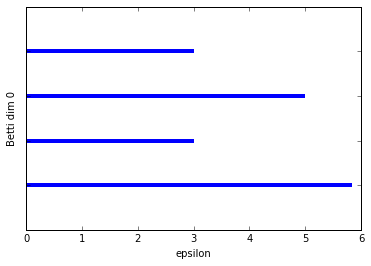

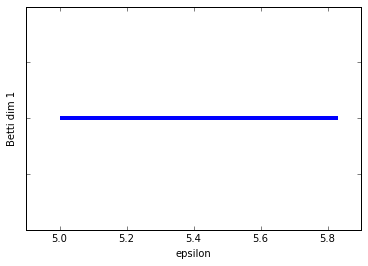

In [102]:
graph_barcode(persist1, 0)
graph_barcode(persist1, 1)

Schweeeeet! Persistent homology, at last!

So we've graphed the barcode diagrams for the first two Betti numbers. The first barcode is a little underwhelming since what we want to see is some bars that are significantly longer than others, indicating a true feature. In this case, the Betti 0 barcode has a longest bar which represents the single connected componenent that is formed with the box, but it's not _that_ much longer then the next longest bar. That's mostly an artifact of the example being so simple. If I had added in a few more points then we would see a more significant longest bar.

The Betti 1 barcode is in a lot better shape. We clearly just have a single long bar indicating the 1-dimensional cycle that exists up until the box "fills in" at $\epsilon = 5.8$.

An important feature of persistent homology is being able to find the data points that lie on some interesting topological feature. If all persistent homology could do was give us barcodes and tell us how many connected components and cycles then that would be useful but wanting.

What we really want to be able to do is say, "hey look, the barcode shows there's a statistically significant 1-dimensional cycle, I wonder which data points form that cycle?"

To test out this procedure, let's modify our simple "box" simplicial complex a bit and add another edge (giving us another connected component).

In [66]:
data_b = np.array([[1,4],[1,1],[6,1],[6,4],[12,3.5],[12,1.5]])

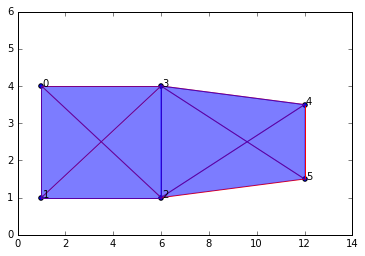

In [76]:
graph2b = buildGraph(raw_data=data_b, epsilon=8) #epsilon is set to a high value to create a maximal complex
rips2b = ripsFiltration(graph2b, k=3)
SimplicialComplex.drawComplex(origData=data_b, ripsComplex=rips2b[0], axes=[0,14,0,6])

The depiction shows the maximal complex since we set $\epsilon$ to be a high value. But I tried to design the data so the "true" features are a box (which is a 1-dim cycle) and an edge off to the right, for a total of two "true" connected components.

Alright, let's run persistent homology on this data.

In [103]:
bm2b = filterBoundaryMatrix(rips2b)
rbm2b = reduceBoundaryMatrix(bm2b)
intervals2b = readIntervals(rbm2b, rips2b[1])
persist2b = readPersistence(intervals2b, rips2b)

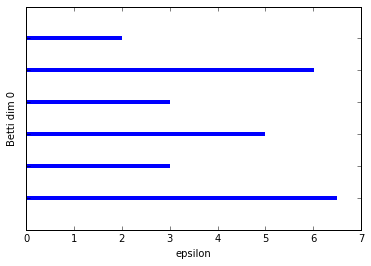

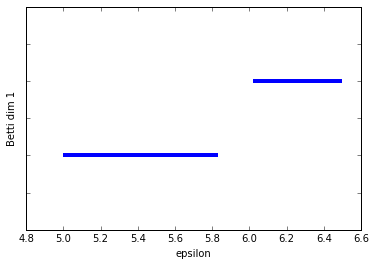

In [104]:
graph_barcode(persist2b, 0)
graph_barcode(persist2b, 1)

We can see the two connected components (the two longest bars) in `Betti dim 0` and we see two bars in `Betti dim 1`, but one is clearly almost twice as long as the other. The shorter bar is from when the edge on the right forms a cycle with the two left-most vertices on the left-sided box.

So at this point we're thinking we have one significant 1-dim cycle, but (pretending we can't just plot our data) we don't know which points form this cycle so that we can further analyze that subset of the data if we wish.

In order to figure that out, we just need to use the _memory_ matrix that our reduction algorithm also returns to us. First we find the interval we want from the `intervals2b` list, in this case it is the first element, then we get the start point (since that indicates the birth of the feature). The start point is an index value in the boundary array, so we'll just find that column in the memory array and look for the 1s in that column. The rows with 1s in that column are the other simplices in the group (including the column itself).

In [105]:
persist2b 

[[0, [0, 6.5]],
 [0, [0, 3.0]],
 [0, [0, 5.0]],
 [0, [0, 3.0]],
 [0, [0, 6.0207972893961479]],
 [0, [0, 2.0]],
 [1, [5.0, 5.8309518948453007]],
 [1, [6.0207972893961479, 6.5]]]

First, look at the intervals in homology group 1, then we want the interval that spans the epsilon range from 5.0 to 5.83. That's index 6 in the persistence list, and is likewise index 6 in the intervals list. The intervals list, rather than epsilon start and end, has index values so we can lookup the simplices in the memory matrix.

In [107]:
cycle1 = intervals2b[6]
cycle1
#So birth index is 10

[10, 19]

In [111]:
column10 = rbm2b[1][:,10]
column10

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

So this is the column in the memory matrix with index=10. So we automatically know that whatever simplex is in index 10 is part of the cycle as well as the rows with 1s in this column.

In [120]:
ptsOnCycle = [i for i in range(len(column10)) if column10[i] == 1]
ptsOnCycle

[7, 8, 9, 10]

In [127]:
#so the simplices with indices 7,8,9,10 lie on our 1-dimensional cycle, let's find what those simplices are
rips2b[0][7:11] #range [start:stop], but stop is non-inclusive, so put 11 instead of 10

[{0, 1}, {2, 3}, {1, 2}, {0, 3}]

Exactly! Now this is the list of 1-simplices that form the 1-dimensional cycle we saw in our barcode. It should be trivial to go from this list to the raw data points so I won't bore you with those details here.

Alright. Let's try this with a little bit more realistic data. We'll use data sampled from a circle like we did in the beginning of this section. For this example, I've set the parameter `k=2` in the `ripsFiltration` function so it will only generate simplices up to 2-simplices. This is just to reduce the memory needed. If you have a fast computer with a lot of memory, you're welcome to set `k` to 3 or so, but I wouldn't make it much greater than that. Usually we're mostly interested in connected components and 1 or 2 dimensional cycles. The utility of topological features in dimensions higher than that seems to be a diminishing return and the price in memory and algorithm running time is generally not worth it.

>__NOTE__: The following may take awhile to run, perhaps several minutes. This is because the code written in these tutorials is optimized for clarity and ease, NOT for efficiency or speed. There are a lot of performance optimizations that can and should be made if we wanted to make this anywhere close to a production ready TDA library. I plan to write a follow up post at some point about the most reasonable algorithm and data structure optimizations that we can make because I hope to develop a reasonable efficient open source TDA library in Python in the future and would appreciate any help I can get.

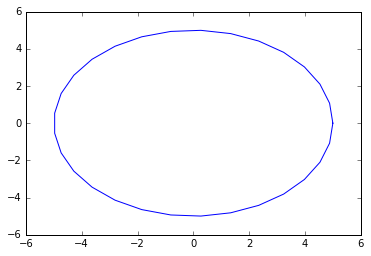

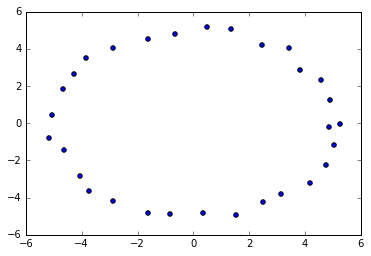

In [155]:
n = 30 #number of points to generate
#generate space of parameter
theta = np.linspace(0, 2.0*np.pi, n) 
a, b, r = 0.0, 0.0, 5.0
x = a + r*np.cos(theta)
y = b + r*np.sin(theta)
#code to plot the circle for visualization
plt.plot(x, y)
plt.show()
xc = np.random.uniform(-0.25,0.25,n) + x #add some "jitteriness" to the points (but less than before, reduces memory)
yc = np.random.uniform(-0.25,0.25,n) + y
fig, ax = plt.subplots()
ax.scatter(xc,yc)
plt.show()
circleData = np.array(list(zip(xc,yc)))

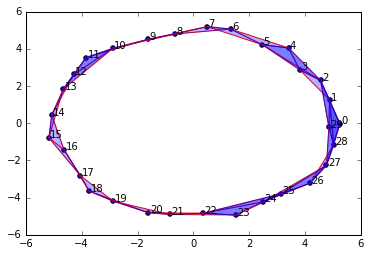

In [159]:
graph4 = buildGraph(raw_data=circleData, epsilon=3.0)
rips4 = ripsFiltration(graph4, k=2)
SimplicialComplex.drawComplex(origData=circleData, ripsComplex=rips4[0], axes=[-6,6,-6,6])

Clearly, persistent homology should tell us we have 1 connected component and a single 1-dimensional cycle.

In [161]:
len(rips4[0])
#On my laptop, a rips filtration with more than about 250 simplices will take >10 mins to compute persistent homology
#anything < ~220 only takes a few minutes or less

148

In [162]:
%%time
bm4 = filterBoundaryMatrix(rips4)
rbm4 = reduceBoundaryMatrix(bm4)
intervals4 = readIntervals(rbm4, rips4[1])
persist4 = readPersistence(intervals4, rips4)

CPU times: user 43.4 s, sys: 199 ms, total: 43.6 s
Wall time: 44.1 s


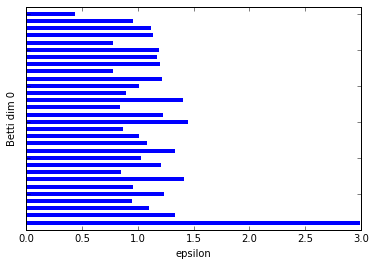

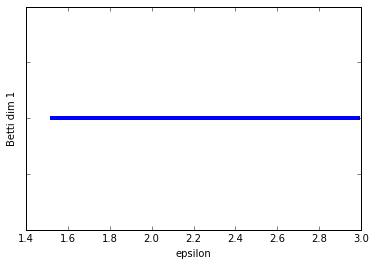

In [163]:
graph_barcode(persist4, 0)
graph_barcode(persist4, 1)

We can clearly see that there is a _significantly_ longer bar than the others in the `Betti dim 0` barcode, indicating we have only one significant connected component. This fits clearly with the circular data we plotted.

The `Betti dim 1` barcode is even easier as it only shows a single bar, so we of course have a significant feature here being a 1-dimensional cycle.

Okay well, as usual, let's make things a little bit tougher to test our algorithms.

We're going to sample points from a shape called a __lemniscate__, more commonly known as a figure-of-eight, since it looks like the number 8 sideways. As you can tell, it should have 1 connected component and two 1-dimensional cycles.

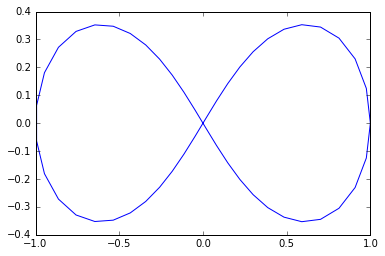

In [166]:
n = 50
t = np.linspace(0, 2*np.pi, num=n)
#equations for lemniscate
x = np.cos(t) / (np.sin(t)**2 + 1)
y = np.cos(t) * np.sin(t) / (np.sin(t)**2 + 1)

plt.plot(x, y)
plt.show()

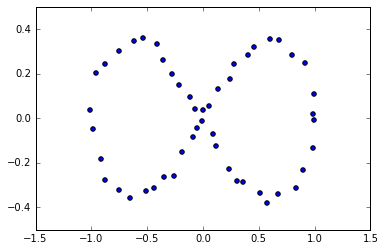

In [167]:
x2 = np.random.uniform(-0.03, 0.03, n) + x #add some "jitteriness" to the points
y2 = np.random.uniform(-0.03, 0.03, n) + y
fig, ax = plt.subplots()
ax.scatter(x2,y2)
plt.show()

In [168]:
figure8Data = np.array(list(zip(x2,y2)))

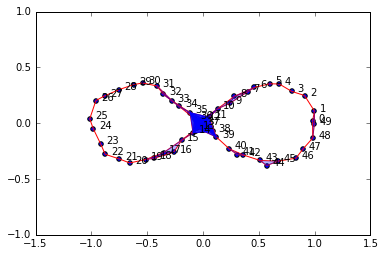

In [169]:
graph5 = buildGraph(raw_data=figure8Data, epsilon=0.2)
rips5 = ripsFiltration(graph5, k=2)
SimplicialComplex.drawComplex(origData=figure8Data, ripsComplex=rips5[0], axes=[-1.5,1.5,-1, 1])

In [170]:
%%time
bm5 = filterBoundaryMatrix(rips5)
rbm5 = reduceBoundaryMatrix(bm5)
intervals5 = readIntervals(rbm5, rips5[1])
persist5 = readPersistence(intervals5, rips5)

CPU times: user 17min 8s, sys: 3.93 s, total: 17min 12s
Wall time: 17min 24s


Yeah... that took 17 minutes. Good thing I still had enough CPU/RAM to watch YouTube.

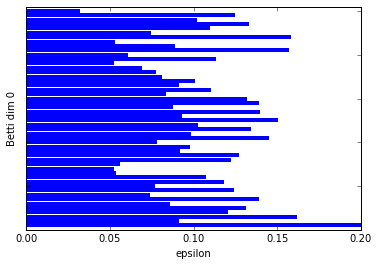

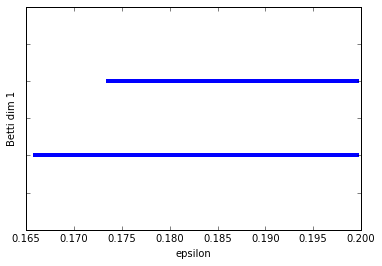

In [172]:
graph_barcode(persist5, 0)
graph_barcode(persist5, 1)

:-) Just as we expected. `Betti dim 0` shows one significantly longer bar than the others and `Betti dim 1` shows us two long bars, our two 1-dim cycles.

Let's add in another component. In this example, I've just added in a small circle in the data. So we should have two connected components and 3 1-dim cycles.

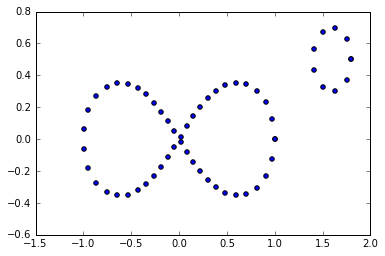

In [173]:
theta = np.linspace(0, 2.0*np.pi, 10) 
a, b, r = 1.6, 0.5, 0.2
x3 = a + r*np.cos(theta)
y3 = b + r*np.sin(theta)
x4 = np.append(x, x3)
y4 = np.append(y, y3)
fig, ax = plt.subplots()
ax.scatter(x4,y4)
plt.show()
figure8Data2 = np.array(list(zip(x4,y4)))
# I didn't add "jitteriness" this time since that increases the complexity of the subsequent simplicial complex, 
# which makes the memory and computation requirements much greater

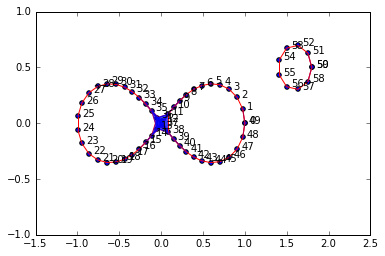

In [174]:
graph6 = buildGraph(raw_data=figure8Data2, epsilon=0.19)
rips6 = ripsFiltration(graph6, k=2)
SimplicialComplex.drawComplex(origData=figure8Data2, ripsComplex=rips6[0], axes=[-1.5,2.5,-1, 1])

In [175]:
len(rips6[0]) #reasonable size

220

In [177]:
%%time
bm6 = filterBoundaryMatrix(rips6)
rbm6 = reduceBoundaryMatrix(bm6)
intervals6 = readIntervals(rbm6, rips6[0])
persist6 = readPersistence(intervals6, rips6)

CPU times: user 4min 2s, sys: 780 ms, total: 4min 2s
Wall time: 4min 4s


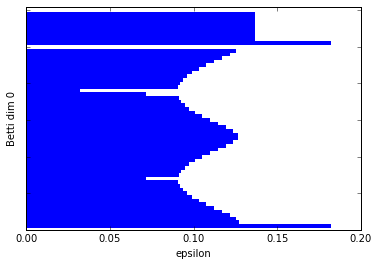

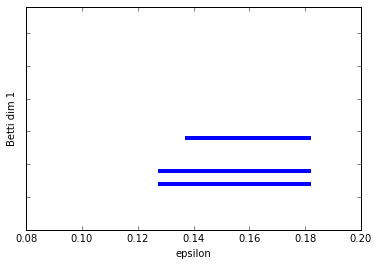

In [178]:
graph_barcode(persist6, 0)
graph_barcode(persist6, 1)

Excellent. I think by now I don't need to tell you how to interpret the barcodes.

### The End... What's next?

Well that's it folks. Part 5 is the end of this sub-series on persistent homology. You now should have all the knowledge necessary to understand and use existing persistent homology software tools, or even build your own if you want.

Next, we will turn our attention to the other major tool in topological data analysis, __mapper__. Mapper is an algorithm that allows us to create visualizable graphs from arbitrarily high-dimensional data. In this way, we are able to see global and local topological features. It is very useful for exploratory data analysis and hypothesis generation. Fortunately, the concepts and math behind it are a lot easier than persistent homology.

#### References (Websites):

1. http://dyinglovegrape.com/math/topology_data_1.php
2. http://www.math.uiuc.edu/~r-ash/Algebra/Chapter4.pdf
3. https://en.wikipedia.org/wiki/Group_(mathematics)
4. https://jeremykun.com/2013/04/03/homology-theory-a-primer/
5. http://suess.sdf-eu.org/website/lang/de/algtop/notes4.pdf
6. http://www.mit.edu/~evanchen/napkin.html
7. https://triangleinequality.wordpress.com/2014/01/23/computing-homology

#### References (Academic Publications):
1. Adams, H., Atanasov, A., & Carlsson, G. (2011). Nudged Elastic Band in Topological Data Analysis. arXiv Preprint, 1112.1993v(December 2011). Retrieved from http://arxiv.org/abs/1112.1993
2. Artamonov, O. (2010). Topological Methods for the Representation and Analysis of Exploration Data in Oil Industry by Oleg Artamonov.
3. Basher, M. (2012). On the Folding of Finite Topological Space. International Mathematical Forum, 7(15), 745–752. Retrieved from http://www.m-hikari.com/imf/imf-2012/13-16-2012/basherIMF13-16-2012.pdf
4. Bauer, U., Kerber, M., & Reininghaus, J. (2013). Distributed computation of persistent homology. arXiv Preprint arXiv:1310.0710, 31–38. http://doi.org/10.1137/1.9781611973198.4
5. Bauer, U., Kerber, M., & Reininghaus, J. (2013). Clear and Compress: Computing Persistent Homology in Chunks. arXiv Preprint arXiv:1303.0477, 1–12. http://doi.org/10.1007/978-3-319-04099-8__7
6. Berry, T., & Sauer, T. (2016). Consistent Manifold Representation for Topological Data Analysis. Retrieved from http://arxiv.org/abs/1606.02353
7. Biasotti, S., Giorgi, D., Spagnuolo, M., & Falcidieno, B. (2008). Reeb graphs for shape analysis and applications. Theoretical Computer Science, 392(1–3), 5–22. http://doi.org/10.1016/j.tcs.2007.10.018
8. Boissonnat, J.-D., & Maria, C. (2014). The Simplex Tree: An Efficient Data Structure for General Simplicial Complexes. Algorithmica, 70(3), 406–427. http://doi.org/10.1007/s00453-014-9887-3
9. Cazals, F., Roth, A., Robert, C., & Christian, M. (2013). Towards Morse Theory for Point Cloud Data, (July). Retrieved from http://hal.archives-ouvertes.fr/hal-00848753/
10. Chazal, F., & Michel, B. (2016). Persistent homology in TDA.
11. Cheng, J. (n.d.). Lecture 16 : Computation of Reeb Graphs Topics in Computational Topology : An Algorithmic View Computation of Reeb Graphs, 1, 1–5.
12. Day, M. (2012). Notes on Cayley Graphs for Math 5123 Cayley graphs, 1–6.
13. Dey, T. K., Fan, F., & Wang, Y. (2013). Graph Induced Complex: A Data Sparsifier for Homology Inference.
14. Doktorova, M. (2012). CONSTRUCTING SIMPLICIAL COMPLEXES OVER by, (June).
15. Edelsbrunner, H. (2006). IV.1 Homology. Computational Topology, 81–87. Retrieved from http://www.cs.duke.edu/courses/fall06/cps296.1/
16. Edelsbrunner, H. (2006). VI.1 Persistent Homology. Computational Topology, 128–134. Retrieved from http://www.cs.duke.edu/courses/fall06/cps296.1/
17. Edelsbrunner, H., Letscher, D., & Zomorodian, A. (n.d.).  a d “ d A ( gpirqtsuGv I ” dfe h d5e x   V  W x ( A x Aji x } ~  k g G  “ f  g I ktg §  y  V  k g G  ” f g I ¨  " f g ¡  k g §  VXW.
18. Edelsbrunner, H., Letscher, D., & Zomorodian, A. (2002). Topological persistence and simplification. Discrete and Computational Geometry, 28(4), 511–533. http://doi.org/10.1007/s00454-002-2885-2
19. Edelsbrunner, H., & Morozov, D. (2012). Persistent homology: theory and practice. 6th European Congress of Mathematics, 123–142. http://doi.org/10.4171/120-1/3
20. Erickson, J. (1908). Homology. Computational Topology, 1–11.
21. Evan Chen. (2016). An Infinitely Large Napkin.
22. Figure, S., & Figure, S. (n.d.). Chapter 4 : Persistent Homology Topics in Computational Topology : An Algorithmic View Persistent homology, 1–8.
23. Grigor’yan, A., Muranov, Y. V., & Yau, S. T. (2014). Graphs associated with simplicial complexes. Homology, Homotopy and Applications, 16(1), 295–311. http://doi.org/10.4310/HHA.2014.v16.n1.a16
24. Kaczynski, T., Mischaikow, K., & Mrozek, M. (2003). Computing homology. Homology, Homotopy and Applications, 5(2), 233–256. http://doi.org/10.4310/HHA.2003.v5.n2.a8
25. Kerber, M. (2016). Persistent Homology – State of the art and challenges 1 Motivation for multi-scale topology. Internat. Math. Nachrichten Nr, 231(231), 15–33.
26. Khoury, M. (n.d.). Lecture 6 : Introduction to Simplicial Homology Topics in Computational Topology : An Algorithmic View, 1–6.
27. Kraft, R. (2016). Illustrations of Data Analysis Using the Mapper Algorithm and Persistent Homology.
28. Lakshmivarahan, S., & Sivakumar, L. (2016). Cayley Graphs, (1), 1–9.
29. Lewis, R. (n.d.). Parallel Computation of Persistent Homology using the Blowup Complex, 323–331. http://doi.org/10.1145/2755573.2755587
30. Liu, X., Xie, Z., & Yi, D. (2012). A fast algorithm for constructing topological structure in large data. Homology, Homotopy and Applications, 14(1), 221–238. http://doi.org/10.4310/HHA.2012.v14.n1.a11
31. Medina, P. S., & Doerge, R. W. (2016). Statistical Methods in Topological Data Analysis for Complex, High-Dimensional Data. Retrieved from http://arxiv.org/abs/1607.05150
32. Morozov, D. (n.d.). A Practical Guide to Persistent Homology A Practical Guide to Persistent Homology.
33. Murty, N. A., Natarajan, V., & Vadhiyar, S. (2013). Efficient homology computations on multicore and manycore systems. 20th Annual International Conference on High Performance Computing, HiPC 2013. http://doi.org/10.1109/HiPC.2013.6799139
34. Naik, V. (2006). Group theory : a first journey, 1–21.
35. Otter, N., Porter, M. A., Tillmann, U., Grindrod, P., & Harrington, H. A. (2015). A roadmap for the computation of persistent homology. Preprint ArXiv, (June), 17. Retrieved from http://arxiv.org/abs/1506.08903
36. Pearson, P. T. (2013). Visualizing Clusters in Artificial Neural Networks Using Morse Theory. Advances in Artificial Neural Systems, 2013, 1–8. http://doi.org/10.1155/2013/486363
37. Reininghaus, J. (2012). Computational Discrete Morse Theory.
38. Reininghaus, J., Huber, S., Bauer, U., Tu, M., & Kwitt, R. (2015). A Stable Multi-Scale Kernel for Topological Machine Learning, 1–8. Retrieved from papers3://publication/uuid/CA230E5C-90AC-4352-80D2-2F556E8B47D3
39. Rykaczewski, K., Wiśniewski, P., & Stencel, K. (n.d.). An Algorithmic Way to Generate Simplexes for Topological Data Analysis.
40. Semester, A. (2017). § 4 . Simplicial Complexes and Simplicial Homology, 1–13.
41. Siles, V. (n.d.). Computing Persistent Homology within Coq / SSReflect, 243847(243847).
42. Singh, G. (2007). Algorithms for Topological Analysis of Data, (November).
43. Tylianakis, J. (2009). Course Notes. Methodology, (2002), 1–124.
44. Wagner, H., & Dłotko, P. (2014). Towards topological analysis of high-dimensional feature spaces. Computer Vision and Image Understanding, 121, 21–26. http://doi.org/10.1016/j.cviu.2014.01.005
45. Xiaoyin Ge, Issam I. Safa, Mikhail Belkin, & Yusu Wang. (2011). Data Skeletonization via Reeb Graphs. Neural Information Processing Systems 2011, 837–845. Retrieved from https://papers.nips.cc/paper/4375-data-skeletonization-via-reeb-graphs.pdf
46. Zomorodian, A. (2010). Fast construction of the Vietoris-Rips complex. Computers and Graphics (Pergamon), 34(3), 263–271. http://doi.org/10.1016/j.cag.2010.03.007
47. Zomorodian, A. (2009). Computational Topology Notes. Advances in Discrete and Computational Geometry, 2, 109–143. Retrieved from http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.50.7483
48. Zomorodian, A. J. (2001). Computing and Comprehending Topology: Persistence and Hierarchical Morse Complexes, 199. Retrieved from http://www.cs.dartmouth.edu/~afra/papers.html
49. Zomorodian, A., & Carlsson, G. (2005). Computing persistent homology. Discrete and Computational Geometry, 33(2), 249–274. http://doi.org/10.1007/s00454-004-1146-y
50. Groups and their Representations Karen E. Smith. (n.d.).
51. Symmetry and Group Theory 1. (2016), 1–18. http://doi.org/10.1016/B978-0-444-53786-7.00026-5